<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2020/blob/master/day-07/MLDM_2020_seminar07_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

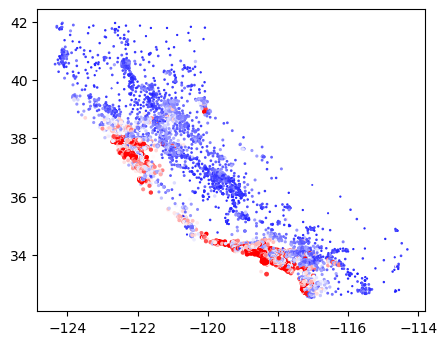

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [4]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


# Task 1 (6 points)

 - Build a kNN regressor on the `Longitude` and `Latitude` features (**1 point**)
 - Build a random forest regressor on the rest of the features (**1 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator (**3 points**)
 - Compare the test MSE losses of the 3 models above (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [6]:
def preprocess_and_create_model(model_class, columns, params={}):
    model = make_pipeline(
        make_column_transformer(
            ("passthrough", columns),
            remainder="drop",
        ),
        model_class(**params),
    )
    return model


Build a kNN regressor on the Longitude and Latitude features (1 point)

In [7]:
knregressor = preprocess_and_create_model(model_class=KNeighborsRegressor, columns=["Latitude",	"Longitude"])
knregressor.fit(X_train, y_train)
print(f"R^2: {knregressor.score(X_test, y_test)}")
y_pred = knregressor.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

R^2: 0.775241703148325
Mean Squared Error: 0.30089594142376896


Build a random forest regressor on the rest of the features (1 point)

In [8]:
rfregressor = preprocess_and_create_model(
    model_class=RandomForestRegressor,
    columns=["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup"],
)
rfregressor.fit(X_train, y_train)
print(f"R^2: {rfregressor.score(X_test, y_test)}")
y_pred = rfregressor.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

R^2: 0.6787256444853003
Mean Squared Error: 0.430107146263463


Build a stacking regressor (sklearn.ensemble.StackingRegressor) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator (3 points)

In [9]:
# Without cross-val-predict
estimators = [
    ("knregressor", preprocess_and_create_model(model_class=KNeighborsRegressor, columns=["Latitude",	"Longitude"])),
    ("rfregressor", preprocess_and_create_model(
    model_class=RandomForestRegressor,
    columns=["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup"],
))
]

reg = StackingRegressor(
     estimators=estimators,
     final_estimator=LinearRegression()
)

reg.fit(X_train, y_train)
print(f"R^2: {reg.score(X_test, y_test)}")
y_pred = reg.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

R^2: 0.8252200440195552
Mean Squared Error: 0.23398726602492007


In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


print("5-fold cross validation scores:\n")
for clf, label in zip(
    [knregressor, rfregressor, reg],
    ["KNeighborsRegressor", "RandomForestRegressor", "StackingRegressor"],
):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


5-fold cross validation scores:

R^2 Score: 0.78 (+/- 0.01) [KNeighborsRegressor]
R^2 Score: 0.69 (+/- 0.01) [RandomForestRegressor]
R^2 Score: 0.84 (+/- 0.01) [StackingRegressor]


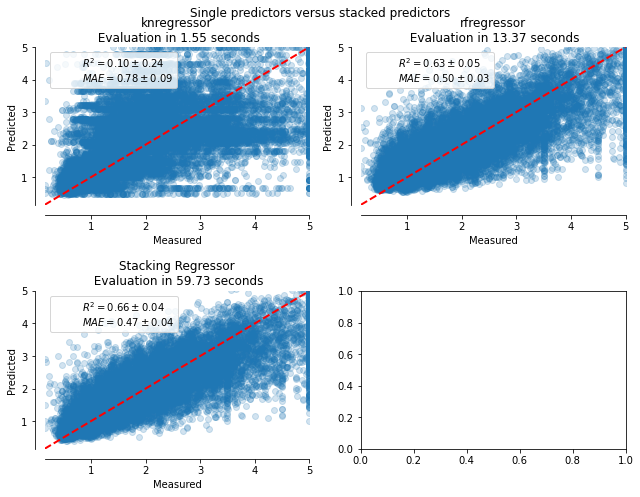

In [11]:
import time
import numpy as np


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               reg)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0, cv=5)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0, cv=5)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Compare the test MSE losses of the 3 models above (1 point)

The MSE of KNeighborsRegressor is 0.30, and the MSE for RandomForestRegressor is 0.43 and the MSE for the StackedRegressor is 0.23. The stacked regressor has the least MSE and is the better performing model. Furthermore the MAE of the Stacked Regressor is also the lowest. The Stacked Regressor also has the best R^2 score with or without cross validation
